# FIFA World Cup 2022 Tweets: Sentiment Analysis

## Importing Packages and Dataset

In [4]:
#%pip install transformers[torch]

In [5]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk import download, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from wordcloud import WordCloud
from scipy.special import softmax
import warnings
import torch
from tqdm.notebook import tqdm
from PIL import Image


warnings.filterwarnings("ignore")

In [46]:
df = pd.read_csv("fifa_world_cup_2022_tweets.csv")
df

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative
...,...,...,...,...,...,...
22519,22519,2022-11-20 00:00:21+00:00,1,Twitter Web App,Here We go World cup 2022 #WorldCup2022,positive
22520,22520,2022-11-20 00:00:03+00:00,0,DenetPro,Anderlecht confirms former Viborg FF's Jesper ...,neutral
22521,22521,2022-11-20 00:00:01+00:00,2,Twitter for iPhone,Great thread to read before the start of #Worl...,positive
22522,22522,2022-11-20 00:00:00+00:00,11,Twitter Web App,Raphinha wants Brazil to be united at the #Wor...,positive


## Cleaning Dataset

In this section, I want to get rid of all the usernames, http links and stopwords with regular expression. After I've done that, I want to tokenize the words and then join them together. This step is preprocessing the text column, so I can use it best for my sntiment analysis.

Furthermore, I want to captilize the first letter of each value in the Sentiment column and drop unnecessary column(s).

In [47]:
df.drop("Unnamed: 0", axis = 1, inplace= True)

In [8]:
df['Sentiment'] = df.Sentiment.str.title()

In [9]:
df.head()

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,Neutral
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,Positive
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,Positive
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,Positive
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",Negative


In [10]:
# using regex to clean the tweets, removing usernames, urls, stopwords, etc.
def preprocess(text):
    text = re.sub(r'(^|\s)@(\w+)', '', text)
    text = re.sub(r'\bhttps?://\S+\b', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(tokens)
    return text

In [11]:
df['preprocessed_tweet'] = df['Tweet'].apply(preprocess)

In [12]:
df.head()

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,preprocessed_tweet
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,Neutral,drinking today worldcup
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,Positive,amazing worldcup launch video shows much face ...
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,Positive,worth reading watching worldcup
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,Positive,golden maknae shinning bright jeonjungkook jun...
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",Negative,bbc cares much human rights homosexual rights ...


## Data Visualization(EDA)

In this section, I want to conduct some Exploratory Data Analysis.

As we can see from the bar plot, most  of the tweets' sentiment are positve, followed by neutral then negative. 

Next, I wanted to take a look at the frequency of each words. As expected, the most common word is "worldcup" with a count of 25792. To visuaize this, I created a wordcloud in the shape of a ball.

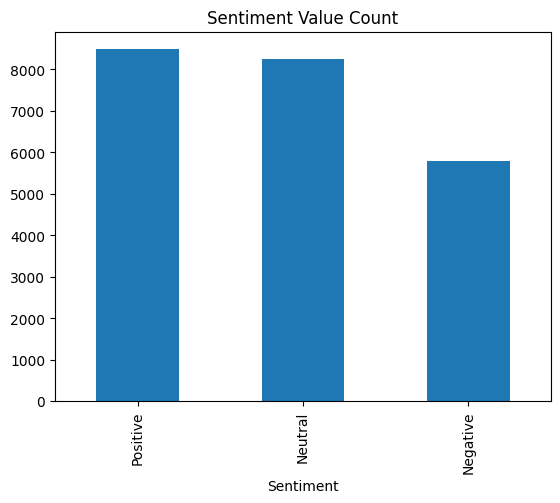

In [13]:
df.Sentiment.value_counts().plot(kind = 'bar')
plt.title("Sentiment Value Count")
plt.show();

In [14]:
word_freq = df.preprocessed_tweet.str.split().explode().value_counts().reset_index()
word_freq.columns = ["Word", "Frequency"]
word_freq['Frequency'] = word_freq.Frequency.astype(int)

word_freq

,Word,Frequency
0,worldcup,25792
1,qatar,8737
2,world,6098
3,cup,5550
4,fifaworldcup,4187
...,...,...
22123,roboooo,1
22124,whst,1
22125,wooooowwwwwwww,1
22126,aaaaah,1


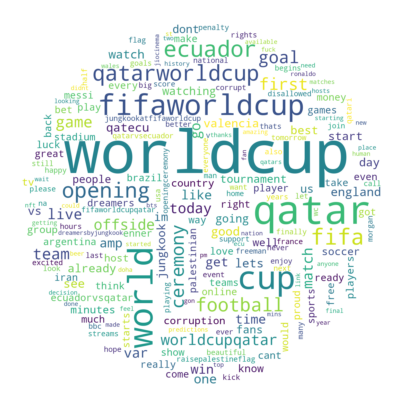

In [15]:
cloud_mask = np.array(Image.open("circle.jpeg"))

# Create a word cloud object
word_freq_dict = word_freq.set_index('Word')['Frequency'].to_dict() # convert dataframe to dictionary object to use generate_from_frequencies
word_cloud = WordCloud(width=1500, height=1500, background_color='white', mask=cloud_mask).generate_from_frequencies(word_freq_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Sentiment Analysis & Prediction

### Vader 

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool specifically designed for analyzing text sentiment in social media content, like tweets and other short texts.

VADER sentiment analysis doesn't rely solely on individual words, but also takes into account the context in which words appear to determine the sentiment of a sentence. It assigns a sentiment polarity to a text on a continuous scale, providing not only whether the text is positive, negative, or neutral, but also a strength of sentiment ranging from very negative to very positive.

However, after doing sentiment analysis on our tweet data, we find that the accuracy is only 58% which is abysmal. 

In [16]:
# Create a SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

In [17]:
# Function to analyze sentiment and return sentiment label
def get_sentiment_label(text):
    sentiment_scores = sia.polarity_scores(text)
    
    if sentiment_scores['compound'] > 0.05:
        return "Positive"
    elif sentiment_scores['compound'] < -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply the sentiment analysis function to the 'text' column
df['vader_sentiment'] = df['preprocessed_tweet'].apply(get_sentiment_label)

In [18]:
df.head()

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,preprocessed_tweet,vader_sentiment
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,Neutral,drinking today worldcup,Neutral
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,Positive,amazing worldcup launch video shows much face ...,Positive
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,Positive,worth reading watching worldcup,Positive
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,Positive,golden maknae shinning bright jeonjungkook jun...,Positive
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",Negative,bbc cares much human rights homosexual rights ...,Neutral


In [19]:
# Calculate the accuracy
correct_predictions = (df['vader_sentiment'] == df['Sentiment']).sum()
total_predictions = len(df)
accuracy = correct_predictions / total_predictions * 100

print("Accuracy: {:.2f}%".format(accuracy))


Accuracy: 58.00%


### XGBoost

In [40]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

In [41]:
# Convert sentiment labels to numerical values
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
df['Sentiment_Num'] = df['Sentiment'].map(sentiment_mapping)

df.head()

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,preprocessed_tweet,vader_sentiment,Roberta,Sentiment_Num
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,Neutral,drinking today worldcup,Neutral,Neutral,1
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,Positive,amazing worldcup launch video shows much face ...,Positive,Positive,2
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,Positive,worth reading watching worldcup,Positive,Neutral,2
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,Positive,golden maknae shinning bright jeonjungkook jun...,Positive,Positive,2
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",Negative,bbc cares much human rights homosexual rights ...,Neutral,Negative,0


In [43]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Sentiment_Num'], test_size=0.2, random_state=42)

vectorizer = CountVectorizer() 
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=3)  # 3 classes: Positive, Neutral, Negative
xgb_classifier.fit(X_train_vec, y_train)

# Make predictions
y_pred = xgb_classifier.predict(X_test_vec)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6943396226415094


### Roberta Model

In [20]:
# Load pre-trained RoBERTa model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"  # You can choose a different variant if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [21]:
def polarity_scores_roberta(Input):
    # Tokenize the input text using the tokenizer
    encoded_text = tokenizer(Input, return_tensors='pt')
    # Pass the tokenized input to the model and get the output
    output = model(**encoded_text)
    # Extract the scores from the output and convert it to a NumPy array
    scores = output[0][0].detach().numpy()
    # Apply softmax on the scores to normalize them
    scores = softmax(scores)
    # Return the normalized scores
    return scores

In [22]:
#df2 = df.head(500) # using only 500 observations

res = []
for i, row in tqdm(df.iterrows(), total=len(df)): 
  text= row['Tweet']
  res.append(polarity_scores_roberta(text))

  0%|          | 0/22524 [00:00<?, ?it/s]

In [23]:
roberta = []

for i in range(len(res)):
  argmax = np.argmax(res[i])
  if argmax == 0:
    roberta.append('negative')
  elif argmax == 1:
    roberta.append('neutral')
  else:
    roberta.append('positive')
df['Roberta'] = roberta

In [44]:
df.head()

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,preprocessed_tweet,vader_sentiment,Roberta,Sentiment_Num
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,Neutral,drinking today worldcup,Neutral,Neutral,1
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,Positive,amazing worldcup launch video shows much face ...,Positive,Positive,2
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,Positive,worth reading watching worldcup,Positive,Neutral,2
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,Positive,golden maknae shinning bright jeonjungkook jun...,Positive,Positive,2
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",Negative,bbc cares much human rights homosexual rights ...,Neutral,Negative,0


In [25]:
df['Roberta'] = df.Roberta.str.title()

# Calculate the accuracy
correct_predictions = (df['Roberta'] == df['Sentiment']).sum()
total_predictions = len(df)
accuracy = correct_predictions / total_predictions * 100

print("Accuracy: {:.2f}%".format(accuracy))

Accuracy: 84.71%


### Finetune Roberta Model with Train Test Split

In [26]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df.Tweet.tolist(), df.Sentiment.tolist(), test_size=0.2, random_state=42)

# Map string labels to integers
label_map = {"Positive": 0, "Negative": 1, "Neutral": 2}
train_labels = [label_map[label] for label in train_labels]
test_labels = [label_map[label] for label in test_labels]

# Tokenize the data
train_encoded = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt", add_special_tokens=True)
test_encoded = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt", add_special_tokens=True)

# Prepare the data for Trainer
train_dataset = torch.utils.data.TensorDataset(train_encoded['input_ids'], train_encoded['attention_mask'], torch.tensor(train_labels))
test_dataset = torch.utils.data.TensorDataset(test_encoded['input_ids'], test_encoded['attention_mask'], torch.tensor(test_labels))

# Create a custom collate function
def custom_collate_fn(batch):
    input_ids = torch.stack([item[0] for item in batch])
    attention_mask = torch.stack([item[1] for item in batch])
    labels = torch.tensor([item[2] for item in batch])
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

# TrainingArguments and Trainer setup
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    eval_steps=100,
    save_total_limit=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=10,
)

# Trainer with custom collate function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=custom_collate_fn,
)

# Fine-tune the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()


  0%|          | 0/3381 [00:00<?, ?it/s]

{'loss': 1.8699, 'learning_rate': 9.970422951789412e-06, 'epoch': 0.01}
{'loss': 1.1963, 'learning_rate': 9.940845903578823e-06, 'epoch': 0.02}
{'loss': 1.0857, 'learning_rate': 9.911268855368235e-06, 'epoch': 0.03}
{'loss': 1.0505, 'learning_rate': 9.881691807157646e-06, 'epoch': 0.04}
{'loss': 1.034, 'learning_rate': 9.852114758947057e-06, 'epoch': 0.04}
{'loss': 0.8835, 'learning_rate': 9.82253771073647e-06, 'epoch': 0.05}
{'loss': 0.6444, 'learning_rate': 9.792960662525881e-06, 'epoch': 0.06}
{'loss': 0.4698, 'learning_rate': 9.763383614315292e-06, 'epoch': 0.07}
{'loss': 0.4269, 'learning_rate': 9.733806566104704e-06, 'epoch': 0.08}
{'loss': 0.488, 'learning_rate': 9.704229517894115e-06, 'epoch': 0.09}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.35239383578300476, 'eval_runtime': 37.6317, 'eval_samples_per_second': 119.713, 'eval_steps_per_second': 7.494, 'epoch': 0.09}
{'loss': 0.4297, 'learning_rate': 9.674652469683526e-06, 'epoch': 0.1}
{'loss': 0.4821, 'learning_rate': 9.645075421472937e-06, 'epoch': 0.11}
{'loss': 0.4021, 'learning_rate': 9.61549837326235e-06, 'epoch': 0.12}
{'loss': 0.3494, 'learning_rate': 9.58592132505176e-06, 'epoch': 0.12}
{'loss': 0.4666, 'learning_rate': 9.556344276841171e-06, 'epoch': 0.13}
{'loss': 0.3071, 'learning_rate': 9.526767228630584e-06, 'epoch': 0.14}
{'loss': 0.2821, 'learning_rate': 9.497190180419995e-06, 'epoch': 0.15}
{'loss': 0.3627, 'learning_rate': 9.467613132209406e-06, 'epoch': 0.16}
{'loss': 0.445, 'learning_rate': 9.438036083998818e-06, 'epoch': 0.17}
{'loss': 0.4368, 'learning_rate': 9.408459035788229e-06, 'epoch': 0.18}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.31992247700691223, 'eval_runtime': 39.6975, 'eval_samples_per_second': 113.483, 'eval_steps_per_second': 7.104, 'epoch': 0.18}
{'loss': 0.4793, 'learning_rate': 9.37888198757764e-06, 'epoch': 0.19}
{'loss': 0.242, 'learning_rate': 9.349304939367051e-06, 'epoch': 0.2}
{'loss': 0.3583, 'learning_rate': 9.319727891156464e-06, 'epoch': 0.2}
{'loss': 0.3363, 'learning_rate': 9.290150842945874e-06, 'epoch': 0.21}
{'loss': 0.4121, 'learning_rate': 9.260573794735285e-06, 'epoch': 0.22}
{'loss': 0.4229, 'learning_rate': 9.230996746524698e-06, 'epoch': 0.23}
{'loss': 0.3436, 'learning_rate': 9.20141969831411e-06, 'epoch': 0.24}
{'loss': 0.3606, 'learning_rate': 9.17184265010352e-06, 'epoch': 0.25}
{'loss': 0.3871, 'learning_rate': 9.142265601892932e-06, 'epoch': 0.26}
{'loss': 0.3282, 'learning_rate': 9.112688553682343e-06, 'epoch': 0.27}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.2718265652656555, 'eval_runtime': 37.577, 'eval_samples_per_second': 119.887, 'eval_steps_per_second': 7.505, 'epoch': 0.27}
{'loss': 0.2453, 'learning_rate': 9.083111505471754e-06, 'epoch': 0.28}
{'loss': 0.3649, 'learning_rate': 9.053534457261165e-06, 'epoch': 0.28}
{'loss': 0.3786, 'learning_rate': 9.023957409050578e-06, 'epoch': 0.29}
{'loss': 0.2963, 'learning_rate': 8.99438036083999e-06, 'epoch': 0.3}
{'loss': 0.4345, 'learning_rate': 8.964803312629399e-06, 'epoch': 0.31}
{'loss': 0.3087, 'learning_rate': 8.935226264418812e-06, 'epoch': 0.32}
{'loss': 0.3736, 'learning_rate': 8.905649216208223e-06, 'epoch': 0.33}
{'loss': 0.2815, 'learning_rate': 8.876072167997635e-06, 'epoch': 0.34}
{'loss': 0.3659, 'learning_rate': 8.846495119787046e-06, 'epoch': 0.35}
{'loss': 0.2659, 'learning_rate': 8.816918071576457e-06, 'epoch': 0.35}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.2742076814174652, 'eval_runtime': 38.1847, 'eval_samples_per_second': 117.979, 'eval_steps_per_second': 7.385, 'epoch': 0.35}
{'loss': 0.2535, 'learning_rate': 8.787341023365868e-06, 'epoch': 0.36}
{'loss': 0.4053, 'learning_rate': 8.75776397515528e-06, 'epoch': 0.37}
{'loss': 0.2634, 'learning_rate': 8.728186926944692e-06, 'epoch': 0.38}
{'loss': 0.4383, 'learning_rate': 8.698609878734104e-06, 'epoch': 0.39}
{'loss': 0.4007, 'learning_rate': 8.669032830523515e-06, 'epoch': 0.4}
{'loss': 0.3185, 'learning_rate': 8.639455782312926e-06, 'epoch': 0.41}
{'loss': 0.4429, 'learning_rate': 8.609878734102337e-06, 'epoch': 0.42}
{'loss': 0.3312, 'learning_rate': 8.580301685891749e-06, 'epoch': 0.43}
{'loss': 0.2442, 'learning_rate': 8.55072463768116e-06, 'epoch': 0.43}
{'loss': 0.3081, 'learning_rate': 8.521147589470573e-06, 'epoch': 0.44}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.27865880727767944, 'eval_runtime': 38.7089, 'eval_samples_per_second': 116.382, 'eval_steps_per_second': 7.285, 'epoch': 0.44}
{'loss': 0.3733, 'learning_rate': 8.491570541259982e-06, 'epoch': 0.45}
{'loss': 0.3972, 'learning_rate': 8.461993493049394e-06, 'epoch': 0.46}
{'loss': 0.2864, 'learning_rate': 8.432416444838806e-06, 'epoch': 0.47}
{'loss': 0.2797, 'learning_rate': 8.402839396628218e-06, 'epoch': 0.48}
{'loss': 0.2376, 'learning_rate': 8.373262348417629e-06, 'epoch': 0.49}
{'loss': 0.2879, 'learning_rate': 8.34368530020704e-06, 'epoch': 0.5}
{'loss': 0.2531, 'learning_rate': 8.314108251996451e-06, 'epoch': 0.51}
{'loss': 0.3447, 'learning_rate': 8.284531203785863e-06, 'epoch': 0.51}
{'loss': 0.2411, 'learning_rate': 8.254954155575274e-06, 'epoch': 0.52}
{'loss': 0.3178, 'learning_rate': 8.225377107364687e-06, 'epoch': 0.53}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.3051053583621979, 'eval_runtime': 38.7363, 'eval_samples_per_second': 116.299, 'eval_steps_per_second': 7.28, 'epoch': 0.53}
{'loss': 0.264, 'learning_rate': 8.195800059154098e-06, 'epoch': 0.54}
{'loss': 0.3482, 'learning_rate': 8.166223010943508e-06, 'epoch': 0.55}
{'loss': 0.3242, 'learning_rate': 8.13664596273292e-06, 'epoch': 0.56}
{'loss': 0.3878, 'learning_rate': 8.107068914522332e-06, 'epoch': 0.57}
{'loss': 0.2435, 'learning_rate': 8.077491866311743e-06, 'epoch': 0.58}
{'loss': 0.3774, 'learning_rate': 8.047914818101154e-06, 'epoch': 0.59}
{'loss': 0.2998, 'learning_rate': 8.018337769890565e-06, 'epoch': 0.59}
{'loss': 0.391, 'learning_rate': 7.988760721679977e-06, 'epoch': 0.6}
{'loss': 0.3321, 'learning_rate': 7.959183673469388e-06, 'epoch': 0.61}
{'loss': 0.3397, 'learning_rate': 7.9296066252588e-06, 'epoch': 0.62}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.2628634572029114, 'eval_runtime': 37.8251, 'eval_samples_per_second': 119.101, 'eval_steps_per_second': 7.455, 'epoch': 0.62}
{'loss': 0.2842, 'learning_rate': 7.900029577048212e-06, 'epoch': 0.63}
{'loss': 0.3582, 'learning_rate': 7.870452528837622e-06, 'epoch': 0.64}
{'loss': 0.2414, 'learning_rate': 7.840875480627035e-06, 'epoch': 0.65}
{'loss': 0.3457, 'learning_rate': 7.811298432416446e-06, 'epoch': 0.66}
{'loss': 0.3204, 'learning_rate': 7.781721384205857e-06, 'epoch': 0.67}
{'loss': 0.3237, 'learning_rate': 7.752144335995268e-06, 'epoch': 0.67}
{'loss': 0.3273, 'learning_rate': 7.72256728778468e-06, 'epoch': 0.68}
{'loss': 0.3779, 'learning_rate': 7.69299023957409e-06, 'epoch': 0.69}
{'loss': 0.2402, 'learning_rate': 7.663413191363502e-06, 'epoch': 0.7}
{'loss': 0.2883, 'learning_rate': 7.633836143152913e-06, 'epoch': 0.71}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.2557736039161682, 'eval_runtime': 37.1651, 'eval_samples_per_second': 121.216, 'eval_steps_per_second': 7.588, 'epoch': 0.71}
{'loss': 0.3437, 'learning_rate': 7.604259094942325e-06, 'epoch': 0.72}
{'loss': 0.166, 'learning_rate': 7.574682046731737e-06, 'epoch': 0.73}
{'loss': 0.2501, 'learning_rate': 7.545104998521148e-06, 'epoch': 0.74}
{'loss': 0.2254, 'learning_rate': 7.515527950310559e-06, 'epoch': 0.75}
{'loss': 0.4241, 'learning_rate': 7.485950902099971e-06, 'epoch': 0.75}
{'loss': 0.314, 'learning_rate': 7.456373853889382e-06, 'epoch': 0.76}
{'loss': 0.242, 'learning_rate': 7.426796805678794e-06, 'epoch': 0.77}
{'loss': 0.2143, 'learning_rate': 7.397219757468205e-06, 'epoch': 0.78}
{'loss': 0.2813, 'learning_rate': 7.367642709257616e-06, 'epoch': 0.79}
{'loss': 0.3342, 'learning_rate': 7.338065661047028e-06, 'epoch': 0.8}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.2596639096736908, 'eval_runtime': 37.3226, 'eval_samples_per_second': 120.704, 'eval_steps_per_second': 7.556, 'epoch': 0.8}
{'loss': 0.4161, 'learning_rate': 7.308488612836439e-06, 'epoch': 0.81}
{'loss': 0.3591, 'learning_rate': 7.278911564625851e-06, 'epoch': 0.82}
{'loss': 0.2791, 'learning_rate': 7.249334516415263e-06, 'epoch': 0.83}
{'loss': 0.2331, 'learning_rate': 7.219757468204673e-06, 'epoch': 0.83}
{'loss': 0.2337, 'learning_rate': 7.190180419994085e-06, 'epoch': 0.84}
{'loss': 0.2952, 'learning_rate': 7.160603371783496e-06, 'epoch': 0.85}
{'loss': 0.3227, 'learning_rate': 7.131026323572908e-06, 'epoch': 0.86}
{'loss': 0.2374, 'learning_rate': 7.10144927536232e-06, 'epoch': 0.87}
{'loss': 0.1978, 'learning_rate': 7.07187222715173e-06, 'epoch': 0.88}
{'loss': 0.2847, 'learning_rate': 7.042295178941142e-06, 'epoch': 0.89}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.26624682545661926, 'eval_runtime': 37.421, 'eval_samples_per_second': 120.387, 'eval_steps_per_second': 7.536, 'epoch': 0.89}
{'loss': 0.2706, 'learning_rate': 7.012718130730553e-06, 'epoch': 0.9}
{'loss': 0.3131, 'learning_rate': 6.983141082519965e-06, 'epoch': 0.91}
{'loss': 0.2388, 'learning_rate': 6.953564034309377e-06, 'epoch': 0.91}
{'loss': 0.3206, 'learning_rate': 6.923986986098787e-06, 'epoch': 0.92}
{'loss': 0.3022, 'learning_rate': 6.894409937888199e-06, 'epoch': 0.93}
{'loss': 0.2091, 'learning_rate': 6.86483288967761e-06, 'epoch': 0.94}
{'loss': 0.2703, 'learning_rate': 6.8352558414670224e-06, 'epoch': 0.95}
{'loss': 0.2846, 'learning_rate': 6.805678793256434e-06, 'epoch': 0.96}
{'loss': 0.357, 'learning_rate': 6.776101745045846e-06, 'epoch': 0.97}
{'loss': 0.2673, 'learning_rate': 6.746524696835256e-06, 'epoch': 0.98}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.23440301418304443, 'eval_runtime': 37.5306, 'eval_samples_per_second': 120.035, 'eval_steps_per_second': 7.514, 'epoch': 0.98}
{'loss': 0.234, 'learning_rate': 6.716947648624667e-06, 'epoch': 0.98}
{'loss': 0.3197, 'learning_rate': 6.6873706004140795e-06, 'epoch': 0.99}
{'loss': 0.1941, 'learning_rate': 6.657793552203491e-06, 'epoch': 1.0}
{'loss': 0.2013, 'learning_rate': 6.628216503992903e-06, 'epoch': 1.01}
{'loss': 0.1375, 'learning_rate': 6.598639455782313e-06, 'epoch': 1.02}
{'loss': 0.1661, 'learning_rate': 6.569062407571724e-06, 'epoch': 1.03}
{'loss': 0.1825, 'learning_rate': 6.5394853593611365e-06, 'epoch': 1.04}
{'loss': 0.2552, 'learning_rate': 6.509908311150548e-06, 'epoch': 1.05}
{'loss': 0.1098, 'learning_rate': 6.48033126293996e-06, 'epoch': 1.06}
{'loss': 0.189, 'learning_rate': 6.45075421472937e-06, 'epoch': 1.06}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.2987563908100128, 'eval_runtime': 37.5882, 'eval_samples_per_second': 119.851, 'eval_steps_per_second': 7.502, 'epoch': 1.06}
{'loss': 0.1483, 'learning_rate': 6.421177166518781e-06, 'epoch': 1.07}
{'loss': 0.2447, 'learning_rate': 6.3916001183081935e-06, 'epoch': 1.08}
{'loss': 0.2152, 'learning_rate': 6.362023070097605e-06, 'epoch': 1.09}
{'loss': 0.1847, 'learning_rate': 6.332446021887017e-06, 'epoch': 1.1}
{'loss': 0.2829, 'learning_rate': 6.302868973676428e-06, 'epoch': 1.11}
{'loss': 0.1442, 'learning_rate': 6.2732919254658384e-06, 'epoch': 1.12}
{'loss': 0.214, 'learning_rate': 6.2437148772552505e-06, 'epoch': 1.13}
{'loss': 0.2641, 'learning_rate': 6.214137829044662e-06, 'epoch': 1.14}
{'loss': 0.3218, 'learning_rate': 6.184560780834074e-06, 'epoch': 1.14}
{'loss': 0.1305, 'learning_rate': 6.154983732623485e-06, 'epoch': 1.15}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.2465977966785431, 'eval_runtime': 37.601, 'eval_samples_per_second': 119.811, 'eval_steps_per_second': 7.5, 'epoch': 1.15}
{'loss': 0.2622, 'learning_rate': 6.1254066844128955e-06, 'epoch': 1.16}
{'loss': 0.1507, 'learning_rate': 6.0958296362023075e-06, 'epoch': 1.17}
{'loss': 0.1528, 'learning_rate': 6.066252587991719e-06, 'epoch': 1.18}
{'loss': 0.1661, 'learning_rate': 6.036675539781131e-06, 'epoch': 1.19}
{'loss': 0.2129, 'learning_rate': 6.007098491570542e-06, 'epoch': 1.2}
{'loss': 0.2264, 'learning_rate': 5.9775214433599525e-06, 'epoch': 1.21}
{'loss': 0.2104, 'learning_rate': 5.9479443951493646e-06, 'epoch': 1.22}
{'loss': 0.1971, 'learning_rate': 5.918367346938776e-06, 'epoch': 1.22}
{'loss': 0.2726, 'learning_rate': 5.888790298728188e-06, 'epoch': 1.23}
{'loss': 0.3078, 'learning_rate': 5.859213250517599e-06, 'epoch': 1.24}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.2605326175689697, 'eval_runtime': 37.3568, 'eval_samples_per_second': 120.594, 'eval_steps_per_second': 7.549, 'epoch': 1.24}
{'loss': 0.1339, 'learning_rate': 5.82963620230701e-06, 'epoch': 1.25}
{'loss': 0.1694, 'learning_rate': 5.800059154096422e-06, 'epoch': 1.26}
{'loss': 0.1271, 'learning_rate': 5.770482105885833e-06, 'epoch': 1.27}
{'loss': 0.1566, 'learning_rate': 5.740905057675245e-06, 'epoch': 1.28}
{'loss': 0.2737, 'learning_rate': 5.711328009464656e-06, 'epoch': 1.29}
{'loss': 0.3012, 'learning_rate': 5.681750961254067e-06, 'epoch': 1.3}
{'loss': 0.2361, 'learning_rate': 5.652173913043479e-06, 'epoch': 1.3}
{'loss': 0.2375, 'learning_rate': 5.62259686483289e-06, 'epoch': 1.31}
{'loss': 0.2305, 'learning_rate': 5.593019816622302e-06, 'epoch': 1.32}
{'loss': 0.166, 'learning_rate': 5.563442768411713e-06, 'epoch': 1.33}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.31200969219207764, 'eval_runtime': 37.4311, 'eval_samples_per_second': 120.354, 'eval_steps_per_second': 7.534, 'epoch': 1.33}
{'loss': 0.2015, 'learning_rate': 5.533865720201124e-06, 'epoch': 1.34}
{'loss': 0.1304, 'learning_rate': 5.504288671990536e-06, 'epoch': 1.35}
{'loss': 0.1645, 'learning_rate': 5.474711623779947e-06, 'epoch': 1.36}
{'loss': 0.264, 'learning_rate': 5.445134575569359e-06, 'epoch': 1.37}
{'loss': 0.3316, 'learning_rate': 5.41555752735877e-06, 'epoch': 1.38}
{'loss': 0.1453, 'learning_rate': 5.385980479148181e-06, 'epoch': 1.38}
{'loss': 0.1754, 'learning_rate': 5.3564034309375935e-06, 'epoch': 1.39}
{'loss': 0.2364, 'learning_rate': 5.326826382727004e-06, 'epoch': 1.4}
{'loss': 0.1926, 'learning_rate': 5.297249334516415e-06, 'epoch': 1.41}
{'loss': 0.1229, 'learning_rate': 5.267672286305827e-06, 'epoch': 1.42}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.2905493676662445, 'eval_runtime': 39.8376, 'eval_samples_per_second': 113.084, 'eval_steps_per_second': 7.079, 'epoch': 1.42}
{'loss': 0.1976, 'learning_rate': 5.2380952380952384e-06, 'epoch': 1.43}
{'loss': 0.2576, 'learning_rate': 5.2085181898846505e-06, 'epoch': 1.44}
{'loss': 0.1724, 'learning_rate': 5.178941141674061e-06, 'epoch': 1.45}
{'loss': 0.213, 'learning_rate': 5.149364093463472e-06, 'epoch': 1.46}
{'loss': 0.2671, 'learning_rate': 5.119787045252884e-06, 'epoch': 1.46}
{'loss': 0.1668, 'learning_rate': 5.0902099970422955e-06, 'epoch': 1.47}
{'loss': 0.1663, 'learning_rate': 5.0606329488317075e-06, 'epoch': 1.48}
{'loss': 0.3121, 'learning_rate': 5.031055900621118e-06, 'epoch': 1.49}
{'loss': 0.2034, 'learning_rate': 5.001478852410529e-06, 'epoch': 1.5}
{'loss': 0.1563, 'learning_rate': 4.971901804199941e-06, 'epoch': 1.51}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.2543196380138397, 'eval_runtime': 38.4307, 'eval_samples_per_second': 117.224, 'eval_steps_per_second': 7.338, 'epoch': 1.51}
{'loss': 0.2209, 'learning_rate': 4.9423247559893525e-06, 'epoch': 1.52}
{'loss': 0.2427, 'learning_rate': 4.912747707778764e-06, 'epoch': 1.53}
{'loss': 0.1752, 'learning_rate': 4.883170659568176e-06, 'epoch': 1.54}
{'loss': 0.215, 'learning_rate': 4.853593611357587e-06, 'epoch': 1.54}
{'loss': 0.2524, 'learning_rate': 4.824016563146998e-06, 'epoch': 1.55}
{'loss': 0.2273, 'learning_rate': 4.7944395149364095e-06, 'epoch': 1.56}
{'loss': 0.2925, 'learning_rate': 4.764862466725822e-06, 'epoch': 1.57}
{'loss': 0.1657, 'learning_rate': 4.735285418515233e-06, 'epoch': 1.58}
{'loss': 0.1927, 'learning_rate': 4.705708370304644e-06, 'epoch': 1.59}
{'loss': 0.2056, 'learning_rate': 4.676131322094055e-06, 'epoch': 1.6}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.2476370632648468, 'eval_runtime': 38.6416, 'eval_samples_per_second': 116.584, 'eval_steps_per_second': 7.298, 'epoch': 1.6}
{'loss': 0.2131, 'learning_rate': 4.6465542738834665e-06, 'epoch': 1.61}
{'loss': 0.1839, 'learning_rate': 4.616977225672879e-06, 'epoch': 1.61}
{'loss': 0.258, 'learning_rate': 4.58740017746229e-06, 'epoch': 1.62}
{'loss': 0.1896, 'learning_rate': 4.557823129251701e-06, 'epoch': 1.63}
{'loss': 0.1619, 'learning_rate': 4.528246081041112e-06, 'epoch': 1.64}
{'loss': 0.237, 'learning_rate': 4.4986690328305236e-06, 'epoch': 1.65}
{'loss': 0.2113, 'learning_rate': 4.469091984619936e-06, 'epoch': 1.66}
{'loss': 0.1432, 'learning_rate': 4.439514936409347e-06, 'epoch': 1.67}
{'loss': 0.1921, 'learning_rate': 4.409937888198758e-06, 'epoch': 1.68}
{'loss': 0.1673, 'learning_rate': 4.380360839988169e-06, 'epoch': 1.69}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.3152260184288025, 'eval_runtime': 38.5748, 'eval_samples_per_second': 116.786, 'eval_steps_per_second': 7.31, 'epoch': 1.69}
{'loss': 0.1823, 'learning_rate': 4.3507837917775806e-06, 'epoch': 1.69}
{'loss': 0.1524, 'learning_rate': 4.321206743566993e-06, 'epoch': 1.7}
{'loss': 0.2897, 'learning_rate': 4.291629695356404e-06, 'epoch': 1.71}
{'loss': 0.1362, 'learning_rate': 4.262052647145815e-06, 'epoch': 1.72}
{'loss': 0.1401, 'learning_rate': 4.232475598935226e-06, 'epoch': 1.73}
{'loss': 0.2355, 'learning_rate': 4.202898550724638e-06, 'epoch': 1.74}
{'loss': 0.1455, 'learning_rate': 4.17332150251405e-06, 'epoch': 1.75}
{'loss': 0.1804, 'learning_rate': 4.143744454303461e-06, 'epoch': 1.76}
{'loss': 0.0737, 'learning_rate': 4.114167406092872e-06, 'epoch': 1.77}
{'loss': 0.2279, 'learning_rate': 4.084590357882283e-06, 'epoch': 1.77}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.35538673400878906, 'eval_runtime': 38.8594, 'eval_samples_per_second': 115.931, 'eval_steps_per_second': 7.257, 'epoch': 1.77}
{'loss': 0.2252, 'learning_rate': 4.055013309671695e-06, 'epoch': 1.78}
{'loss': 0.1909, 'learning_rate': 4.025436261461107e-06, 'epoch': 1.79}
{'loss': 0.2301, 'learning_rate': 3.995859213250518e-06, 'epoch': 1.8}
{'loss': 0.2302, 'learning_rate': 3.966282165039929e-06, 'epoch': 1.81}
{'loss': 0.2031, 'learning_rate': 3.93670511682934e-06, 'epoch': 1.82}
{'loss': 0.1521, 'learning_rate': 3.9071280686187525e-06, 'epoch': 1.83}
{'loss': 0.2222, 'learning_rate': 3.877551020408164e-06, 'epoch': 1.84}
{'loss': 0.1539, 'learning_rate': 3.847973972197575e-06, 'epoch': 1.85}
{'loss': 0.1676, 'learning_rate': 3.818396923986986e-06, 'epoch': 1.85}
{'loss': 0.2224, 'learning_rate': 3.788819875776398e-06, 'epoch': 1.86}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.2868574261665344, 'eval_runtime': 38.1682, 'eval_samples_per_second': 118.03, 'eval_steps_per_second': 7.388, 'epoch': 1.86}
{'loss': 0.2256, 'learning_rate': 3.7592428275658095e-06, 'epoch': 1.87}
{'loss': 0.1825, 'learning_rate': 3.7296657793552203e-06, 'epoch': 1.88}
{'loss': 0.2329, 'learning_rate': 3.700088731144632e-06, 'epoch': 1.89}
{'loss': 0.2152, 'learning_rate': 3.6705116829340436e-06, 'epoch': 1.9}
{'loss': 0.1367, 'learning_rate': 3.640934634723455e-06, 'epoch': 1.91}
{'loss': 0.2443, 'learning_rate': 3.6113575865128665e-06, 'epoch': 1.92}
{'loss': 0.1361, 'learning_rate': 3.5817805383022773e-06, 'epoch': 1.93}
{'loss': 0.1172, 'learning_rate': 3.552203490091689e-06, 'epoch': 1.93}
{'loss': 0.2237, 'learning_rate': 3.5226264418811007e-06, 'epoch': 1.94}
{'loss': 0.2562, 'learning_rate': 3.493049393670512e-06, 'epoch': 1.95}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.2976354956626892, 'eval_runtime': 38.9483, 'eval_samples_per_second': 115.666, 'eval_steps_per_second': 7.24, 'epoch': 1.95}
{'loss': 0.3298, 'learning_rate': 3.4634723454599236e-06, 'epoch': 1.96}
{'loss': 0.2257, 'learning_rate': 3.433895297249335e-06, 'epoch': 1.97}
{'loss': 0.241, 'learning_rate': 3.404318249038746e-06, 'epoch': 1.98}
{'loss': 0.2774, 'learning_rate': 3.3747412008281577e-06, 'epoch': 1.99}
{'loss': 0.1818, 'learning_rate': 3.345164152617569e-06, 'epoch': 2.0}
{'loss': 0.1264, 'learning_rate': 3.3155871044069806e-06, 'epoch': 2.01}
{'loss': 0.1405, 'learning_rate': 3.286010056196392e-06, 'epoch': 2.01}
{'loss': 0.0956, 'learning_rate': 3.256433007985803e-06, 'epoch': 2.02}
{'loss': 0.0775, 'learning_rate': 3.2268559597752147e-06, 'epoch': 2.03}
{'loss': 0.0955, 'learning_rate': 3.1972789115646264e-06, 'epoch': 2.04}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.35348233580589294, 'eval_runtime': 40.3949, 'eval_samples_per_second': 111.524, 'eval_steps_per_second': 6.981, 'epoch': 2.04}
{'loss': 0.0625, 'learning_rate': 3.1677018633540376e-06, 'epoch': 2.05}
{'loss': 0.121, 'learning_rate': 3.138124815143449e-06, 'epoch': 2.06}
{'loss': 0.0883, 'learning_rate': 3.10854776693286e-06, 'epoch': 2.07}
{'loss': 0.1758, 'learning_rate': 3.0789707187222717e-06, 'epoch': 2.08}
{'loss': 0.1172, 'learning_rate': 3.0493936705116834e-06, 'epoch': 2.09}
{'loss': 0.162, 'learning_rate': 3.019816622301094e-06, 'epoch': 2.09}
{'loss': 0.1161, 'learning_rate': 2.990239574090506e-06, 'epoch': 2.1}
{'loss': 0.1196, 'learning_rate': 2.9606625258799175e-06, 'epoch': 2.11}
{'loss': 0.1014, 'learning_rate': 2.9310854776693287e-06, 'epoch': 2.12}
{'loss': 0.1972, 'learning_rate': 2.9015084294587404e-06, 'epoch': 2.13}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.4338337481021881, 'eval_runtime': 38.264, 'eval_samples_per_second': 117.735, 'eval_steps_per_second': 7.37, 'epoch': 2.13}
{'loss': 0.1432, 'learning_rate': 2.8719313812481512e-06, 'epoch': 2.14}
{'loss': 0.1456, 'learning_rate': 2.842354333037563e-06, 'epoch': 2.15}
{'loss': 0.1341, 'learning_rate': 2.8127772848269745e-06, 'epoch': 2.16}
{'loss': 0.0714, 'learning_rate': 2.7832002366163858e-06, 'epoch': 2.17}
{'loss': 0.1675, 'learning_rate': 2.7536231884057974e-06, 'epoch': 2.17}
{'loss': 0.1431, 'learning_rate': 2.724046140195209e-06, 'epoch': 2.18}
{'loss': 0.2299, 'learning_rate': 2.69446909198462e-06, 'epoch': 2.19}
{'loss': 0.294, 'learning_rate': 2.6648920437740316e-06, 'epoch': 2.2}
{'loss': 0.1128, 'learning_rate': 2.6353149955634428e-06, 'epoch': 2.21}
{'loss': 0.1779, 'learning_rate': 2.6057379473528544e-06, 'epoch': 2.22}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.3346981406211853, 'eval_runtime': 39.5183, 'eval_samples_per_second': 113.998, 'eval_steps_per_second': 7.136, 'epoch': 2.22}
{'loss': 0.1077, 'learning_rate': 2.576160899142266e-06, 'epoch': 2.23}
{'loss': 0.0857, 'learning_rate': 2.546583850931677e-06, 'epoch': 2.24}
{'loss': 0.109, 'learning_rate': 2.5170068027210886e-06, 'epoch': 2.24}
{'loss': 0.0642, 'learning_rate': 2.4874297545105e-06, 'epoch': 2.25}
{'loss': 0.3233, 'learning_rate': 2.4578527062999115e-06, 'epoch': 2.26}
{'loss': 0.221, 'learning_rate': 2.428275658089323e-06, 'epoch': 2.27}
{'loss': 0.1863, 'learning_rate': 2.3986986098787344e-06, 'epoch': 2.28}
{'loss': 0.1721, 'learning_rate': 2.3691215616681456e-06, 'epoch': 2.29}
{'loss': 0.1806, 'learning_rate': 2.339544513457557e-06, 'epoch': 2.3}
{'loss': 0.1224, 'learning_rate': 2.3099674652469685e-06, 'epoch': 2.31}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.3444347381591797, 'eval_runtime': 38.5061, 'eval_samples_per_second': 116.994, 'eval_steps_per_second': 7.324, 'epoch': 2.31}
{'loss': 0.092, 'learning_rate': 2.28039041703638e-06, 'epoch': 2.32}
{'loss': 0.0958, 'learning_rate': 2.2508133688257914e-06, 'epoch': 2.32}
{'loss': 0.1576, 'learning_rate': 2.2212363206152026e-06, 'epoch': 2.33}
{'loss': 0.2166, 'learning_rate': 2.1916592724046143e-06, 'epoch': 2.34}
{'loss': 0.2602, 'learning_rate': 2.1620822241940255e-06, 'epoch': 2.35}
{'loss': 0.1571, 'learning_rate': 2.132505175983437e-06, 'epoch': 2.36}
{'loss': 0.1165, 'learning_rate': 2.1029281277728484e-06, 'epoch': 2.37}
{'loss': 0.2412, 'learning_rate': 2.07335107956226e-06, 'epoch': 2.38}
{'loss': 0.2768, 'learning_rate': 2.0437740313516713e-06, 'epoch': 2.39}
{'loss': 0.1687, 'learning_rate': 2.0141969831410825e-06, 'epoch': 2.4}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.38087865710258484, 'eval_runtime': 38.7824, 'eval_samples_per_second': 116.161, 'eval_steps_per_second': 7.271, 'epoch': 2.4}
{'loss': 0.2781, 'learning_rate': 1.984619934930494e-06, 'epoch': 2.4}
{'loss': 0.0664, 'learning_rate': 1.9550428867199054e-06, 'epoch': 2.41}
{'loss': 0.1685, 'learning_rate': 1.925465838509317e-06, 'epoch': 2.42}
{'loss': 0.106, 'learning_rate': 1.8958887902987283e-06, 'epoch': 2.43}
{'loss': 0.1191, 'learning_rate': 1.8663117420881396e-06, 'epoch': 2.44}
{'loss': 0.1166, 'learning_rate': 1.8367346938775512e-06, 'epoch': 2.45}
{'loss': 0.2128, 'learning_rate': 1.8071576456669627e-06, 'epoch': 2.46}
{'loss': 0.1608, 'learning_rate': 1.777580597456374e-06, 'epoch': 2.47}
{'loss': 0.1075, 'learning_rate': 1.7480035492457853e-06, 'epoch': 2.48}
{'loss': 0.2084, 'learning_rate': 1.718426501035197e-06, 'epoch': 2.48}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.3689902424812317, 'eval_runtime': 38.8344, 'eval_samples_per_second': 116.006, 'eval_steps_per_second': 7.262, 'epoch': 2.48}
{'loss': 0.1132, 'learning_rate': 1.6888494528246082e-06, 'epoch': 2.49}
{'loss': 0.153, 'learning_rate': 1.6592724046140197e-06, 'epoch': 2.5}
{'loss': 0.0988, 'learning_rate': 1.629695356403431e-06, 'epoch': 2.51}
{'loss': 0.1666, 'learning_rate': 1.6001183081928426e-06, 'epoch': 2.52}
{'loss': 0.0984, 'learning_rate': 1.570541259982254e-06, 'epoch': 2.53}
{'loss': 0.1933, 'learning_rate': 1.5409642117716653e-06, 'epoch': 2.54}
{'loss': 0.1711, 'learning_rate': 1.5113871635610767e-06, 'epoch': 2.55}
{'loss': 0.2213, 'learning_rate': 1.4818101153504882e-06, 'epoch': 2.56}
{'loss': 0.1219, 'learning_rate': 1.4522330671398996e-06, 'epoch': 2.56}
{'loss': 0.153, 'learning_rate': 1.4226560189293108e-06, 'epoch': 2.57}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.3457258641719818, 'eval_runtime': 38.129, 'eval_samples_per_second': 118.152, 'eval_steps_per_second': 7.396, 'epoch': 2.57}
{'loss': 0.0866, 'learning_rate': 1.3930789707187223e-06, 'epoch': 2.58}
{'loss': 0.0593, 'learning_rate': 1.363501922508134e-06, 'epoch': 2.59}
{'loss': 0.1646, 'learning_rate': 1.3339248742975452e-06, 'epoch': 2.6}
{'loss': 0.1022, 'learning_rate': 1.3043478260869566e-06, 'epoch': 2.61}
{'loss': 0.1936, 'learning_rate': 1.2747707778763679e-06, 'epoch': 2.62}
{'loss': 0.1146, 'learning_rate': 1.2451937296657795e-06, 'epoch': 2.63}
{'loss': 0.1975, 'learning_rate': 1.215616681455191e-06, 'epoch': 2.64}
{'loss': 0.0594, 'learning_rate': 1.1860396332446022e-06, 'epoch': 2.64}
{'loss': 0.1484, 'learning_rate': 1.1564625850340136e-06, 'epoch': 2.65}
{'loss': 0.2078, 'learning_rate': 1.126885536823425e-06, 'epoch': 2.66}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.35379868745803833, 'eval_runtime': 38.323, 'eval_samples_per_second': 117.553, 'eval_steps_per_second': 7.359, 'epoch': 2.66}
{'loss': 0.2028, 'learning_rate': 1.0973084886128365e-06, 'epoch': 2.67}
{'loss': 0.1438, 'learning_rate': 1.067731440402248e-06, 'epoch': 2.68}
{'loss': 0.0486, 'learning_rate': 1.0381543921916594e-06, 'epoch': 2.69}
{'loss': 0.0629, 'learning_rate': 1.0085773439810707e-06, 'epoch': 2.7}
{'loss': 0.1019, 'learning_rate': 9.790002957704823e-07, 'epoch': 2.71}
{'loss': 0.1995, 'learning_rate': 9.494232475598936e-07, 'epoch': 2.72}
{'loss': 0.1508, 'learning_rate': 9.19846199349305e-07, 'epoch': 2.72}
{'loss': 0.1557, 'learning_rate': 8.902691511387164e-07, 'epoch': 2.73}
{'loss': 0.1574, 'learning_rate': 8.606921029281279e-07, 'epoch': 2.74}
{'loss': 0.2204, 'learning_rate': 8.311150547175392e-07, 'epoch': 2.75}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.38180169463157654, 'eval_runtime': 36.9851, 'eval_samples_per_second': 121.806, 'eval_steps_per_second': 7.625, 'epoch': 2.75}
{'loss': 0.1067, 'learning_rate': 8.015380065069507e-07, 'epoch': 2.76}
{'loss': 0.1944, 'learning_rate': 7.71960958296362e-07, 'epoch': 2.77}
{'loss': 0.1449, 'learning_rate': 7.423839100857736e-07, 'epoch': 2.78}
{'loss': 0.1077, 'learning_rate': 7.128068618751849e-07, 'epoch': 2.79}
{'loss': 0.1331, 'learning_rate': 6.832298136645964e-07, 'epoch': 2.8}
{'loss': 0.1335, 'learning_rate': 6.536527654540077e-07, 'epoch': 2.8}
{'loss': 0.1308, 'learning_rate': 6.240757172434192e-07, 'epoch': 2.81}
{'loss': 0.1362, 'learning_rate': 5.944986690328305e-07, 'epoch': 2.82}
{'loss': 0.0542, 'learning_rate': 5.649216208222419e-07, 'epoch': 2.83}
{'loss': 0.1715, 'learning_rate': 5.353445726116534e-07, 'epoch': 2.84}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.3568941652774811, 'eval_runtime': 37.2566, 'eval_samples_per_second': 120.918, 'eval_steps_per_second': 7.569, 'epoch': 2.84}
{'loss': 0.1684, 'learning_rate': 5.057675244010648e-07, 'epoch': 2.85}
{'loss': 0.1725, 'learning_rate': 4.7619047619047623e-07, 'epoch': 2.86}
{'loss': 0.1867, 'learning_rate': 4.466134279798876e-07, 'epoch': 2.87}
{'loss': 0.1669, 'learning_rate': 4.17036379769299e-07, 'epoch': 2.87}
{'loss': 0.1589, 'learning_rate': 3.8745933155871046e-07, 'epoch': 2.88}
{'loss': 0.113, 'learning_rate': 3.5788228334812185e-07, 'epoch': 2.89}
{'loss': 0.1943, 'learning_rate': 3.283052351375333e-07, 'epoch': 2.9}
{'loss': 0.255, 'learning_rate': 2.9872818692694475e-07, 'epoch': 2.91}
{'loss': 0.1361, 'learning_rate': 2.6915113871635614e-07, 'epoch': 2.92}
{'loss': 0.133, 'learning_rate': 2.3957409050576754e-07, 'epoch': 2.93}


  0%|          | 0/282 [00:00<?, ?it/s]

{'eval_loss': 0.37698855996131897, 'eval_runtime': 37.0583, 'eval_samples_per_second': 121.565, 'eval_steps_per_second': 7.61, 'epoch': 2.93}
{'loss': 0.0783, 'learning_rate': 2.0999704229517898e-07, 'epoch': 2.94}
{'loss': 0.0323, 'learning_rate': 1.8041999408459038e-07, 'epoch': 2.95}
{'loss': 0.1434, 'learning_rate': 1.5084294587400177e-07, 'epoch': 2.95}
{'loss': 0.185, 'learning_rate': 1.212658976634132e-07, 'epoch': 2.96}
{'loss': 0.1754, 'learning_rate': 9.168884945282461e-08, 'epoch': 2.97}
{'loss': 0.122, 'learning_rate': 6.211180124223603e-08, 'epoch': 2.98}
{'loss': 0.104, 'learning_rate': 3.2534753031647444e-08, 'epoch': 2.99}
{'loss': 0.0867, 'learning_rate': 2.9577048210588584e-09, 'epoch': 3.0}
{'train_runtime': 3385.7197, 'train_samples_per_second': 15.966, 'train_steps_per_second': 0.999, 'train_loss': 0.24098808689555828, 'epoch': 3.0}


  0%|          | 0/282 [00:00<?, ?it/s]

In [27]:
print(results)

{'eval_loss': 0.3675295114517212, 'eval_runtime': 37.8562, 'eval_samples_per_second': 119.003, 'eval_steps_per_second': 7.449, 'epoch': 3.0}


In [28]:
# Save the model
model.save_pretrained('./fine_tuned_model')

In [29]:
# Save the test dataset
torch.save(test_dataset, 'test_dataset.pt')

In [30]:
test_dataset = torch.load('test_dataset.pt')

# Iterate through the test dataset and print the tensors
for item in test_dataset:
    input_ids, attention_mask, labels = item
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)
    print("=" * 30)
    break # Examine the first tensor

Input IDs: tensor([    0, 44220, 46676,   472,    71,  2086,   112,    12,   288,   136,
         5978,  3422,     4,   849,   597, 28673, 10988,   347,   658,   849,
        10988, 21033,  1864, 18416,   844,  2036,   849, 10988,   347,   658,
          844,  2036,  1205,   640,    90,     4,   876,    73,   298,   673,
         2161, 10127,   306,   506,   771,  1000,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,    

In [31]:
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaForSequenceClassification
from sklearn.metrics import accuracy_score

# Load the fine-tuned model
fine_tuned_model = RobertaForSequenceClassification.from_pretrained('./fine_tuned_model')

# Load the test dataset
test_input_ids = test_encoded['input_ids']
test_attention_mask = test_encoded['attention_mask']
test_labels = torch.tensor(test_labels)

test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16)  # Adjust batch size as needed

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test dataloader
for batch in test_dataloader:
    input_ids, attention_mask, labels = batch
    
    # Get model predictions
    with torch.no_grad():
        logits = fine_tuned_model(input_ids=input_ids, attention_mask=attention_mask).logits
    
    # Convert logits to predicted labels
    predicted_batch_labels = torch.argmax(logits, dim=1).tolist()
    
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted_batch_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print("Accuracy: {:.2f}%".format(accuracy*100))


Accuracy: 91.05%


In [33]:
### Predict on whole dataset
df2 = df.copy()

df2_labels =  df2.Sentiment.tolist()

# Map string labels to integers
label_map = {"Positive": 0, "Negative": 1, "Neutral": 2}
df2_labels = [label_map[label] for label in df2_labels]

# Tokenize the data
df2_encoded = tokenizer(df.Tweet.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt", add_special_tokens=True)

# Prepare the data for Trainer
df2_dataset = torch.utils.data.TensorDataset(df2_encoded['input_ids'], df2_encoded['attention_mask'], torch.tensor(df2_labels))

In [34]:
# Save the test dataset
torch.save(df2_dataset, 'df2.pt')

In [35]:
# Iterate through the test dataset and print the tensors
for item in df2_dataset:
    input_ids, attention_mask, labels = item
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)
    print("=" * 30)
    break # Examine the first tensor

Input IDs: tensor([    0,  2264,    32,    52,  4835,   452,   787,   565,  3964,   260,
          565, 21700,  1437, 50118,  1039, 21067,   387, 12541,  1215,  1437,
        50118,  1039,   462,   330,  3976,  1215,   337,  2977,  1437, 50118,
         1039,   337,  1215,  2977,  4057,  1437, 50118, 50118, 10431, 10988,
          347,   658,   844,  2036,  1205,   640,    90,     4,   876,    73,
          673,  2538,   246,   565,   329,   705,   534,   245,   298,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,    

In [36]:
from transformers import RobertaForSequenceClassification
from sklearn.metrics import accuracy_score

# Load the fine-tuned model
fine_tuned_model = RobertaForSequenceClassification.from_pretrained('./fine_tuned_model')

# Load the df2 dataset
df2_dataset = torch.load('df2.pt')

df2_input_ids = df2_encoded['input_ids']
df2_attention_mask = df2_encoded['attention_mask']
df2_labels = torch.tensor(df2_labels)

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the dataset
for i in range(len(df2_input_ids)):
    input_ids = df2_input_ids[i].unsqueeze(0)
    attention_mask = df2_attention_mask[i].unsqueeze(0)
    label = df2_labels[i].item()

    # Get model predictions
    with torch.no_grad():
        logits = fine_tuned_model(input_ids=input_ids, attention_mask=attention_mask).logits

    # Convert logits to predicted label
    predicted_label = torch.argmax(logits, dim=1).item()

    true_labels.append(label)
    predicted_labels.append(predicted_label)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 96.23%


In [48]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1_score))

Precision: 0.96
Recall: 0.96
F1-Score: 0.96


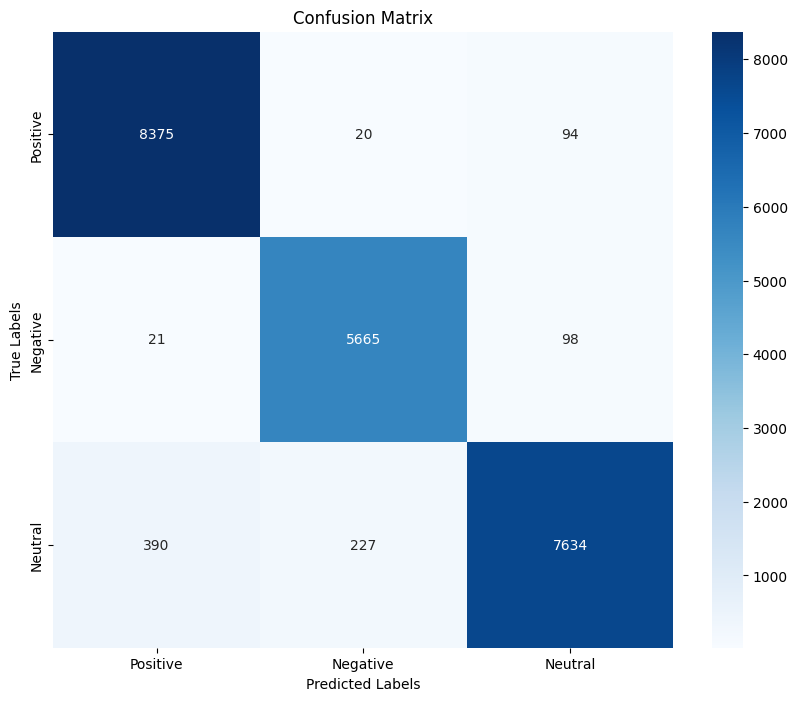

In [49]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()